In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, recall_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [11]:
class AutismDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.filepaths = []
        self.labels = []

        for category in os.listdir(root_dir):
            category_path = os.path.join(root_dir, category)
            if os.path.isdir(category_path):
                label = 0 if category == 'TC' else 1
                for participant_folder in os.listdir(category_path):
                    participant_path = os.path.join(category_path, participant_folder)
                    if os.path.isdir(participant_path):
                        for img_name in os.listdir(participant_path):
                            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                                img_full_path = os.path.join(participant_path, img_name)
                                self.filepaths.append(img_full_path)
                                self.labels.append(label)

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

train_path = "./Dataset_Split4/Augmented_Train"
val_path = "./Dataset_Split4/Validation"
test_path = "./Dataset_Split4/Test"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = AutismDataset(train_path, transform=transform)

def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    num_samples = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        num_samples += batch_samples

    mean /= num_samples
    std /= num_samples
    return mean, std

train_mean, train_std = calculate_mean_std( DataLoader(train_dataset, batch_size=16, shuffle=True))

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean.tolist(), std=train_std.tolist())
])

train_dataset = AutismDataset(train_path, transform=transform)
val_dataset = AutismDataset(val_path, transform=transform)
test_dataset = AutismDataset(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [12]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, 1)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(16)
        self.batch_norm3 = nn.BatchNorm2d(32)
        self.batch_norm4 = nn.BatchNorm2d(32)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.leaky_relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.leaky_relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.leaky_relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = self.leaky_relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = torch.flatten(x, 1)
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x).squeeze()
        x = torch.sigmoid(x)
        return x

/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 9.8461, Val Loss: 0.6425, Train Acc: 0.6295, Val Acc: 0.6778
Epoch [2/50], Train Loss: 0.5731, Val Loss: 0.7045, Train Acc: 0.7070, Val Acc: 0.5778
Epoch [3/50], Train Loss: 0.5359, Val Loss: 0.6711, Train Acc: 0.7329, Val Acc: 0.6333
Epoch [4/50], Train Loss: 0.5278, Val Loss: 0.6778, Train Acc: 0.7416, Val Acc: 0.6222
Epoch [5/50], Train Loss: 0.5205, Val Loss: 0.7059, Train Acc: 0.7444, Val Acc: 0.5556
Epoch [6/50], Train Loss: 0.5182, Val Loss: 0.6513, Train Acc: 0.7410, Val Acc: 0.6111
Epoch [7/50], Train Loss: 0.5102, Val Loss: 0.6570, Train Acc: 0.7531, Val Acc: 0.6222
Epoch [8/50], Train Loss: 0.4669, Val Loss: 0.6462, Train Acc: 0.7728, Val Acc: 0.6333
Epoch [9/50], Train Loss: 0.4462, Val Loss: 0.6377, Train Acc: 0.7801, Val Acc: 0.6556
Epoch [10/50], Train Loss: 0.4346, Val Loss: 0.6063, Train Acc: 0.7949, Val Acc: 0.7111
Epoch [11/50], Train Loss: 0.4149, Val Loss: 0.6084, Train Acc: 0.7986, Val Acc: 0.7111
Epoch [12/50], Train Loss: 0.4175, Val Lo

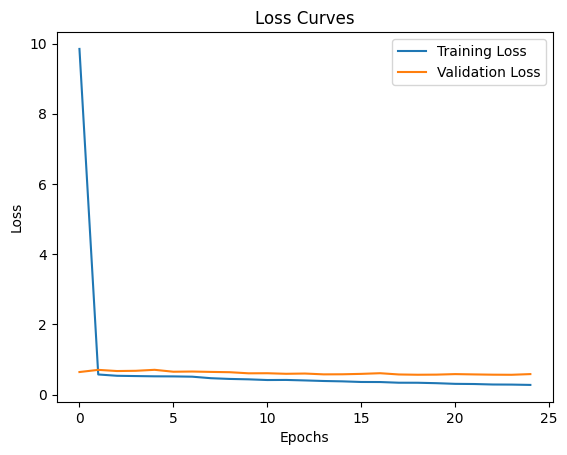

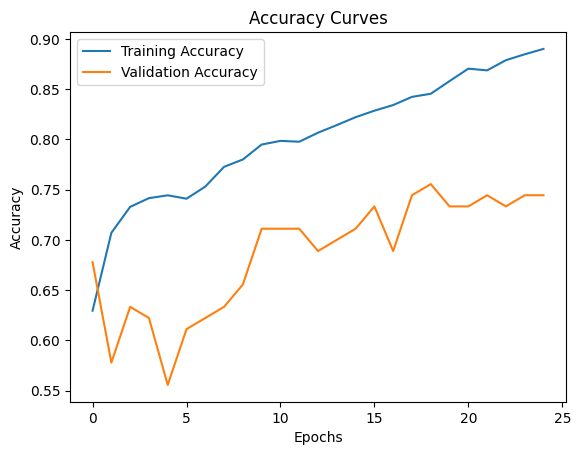

In [13]:
model = CNNModel().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = np.inf

for epoch in range(25):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        labels = labels.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"), dtype=torch.float32).view(-1)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_preds, val_true = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            labels = labels.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"), dtype=torch.float32).view(-1)
            outputs = model(inputs).squeeze()
            val_loss += criterion(outputs, labels).item()
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            val_preds.extend(outputs.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    val_accuracy = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)
    
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(model.state_dict(), "best_model_cnn.pth")

    scheduler.step(val_loss / len(val_loader))

    print(f"Epoch [{epoch+1}/50], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
          f"Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.show()

/tmp/ipykernel_708839/3948288324.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_model_cnn.pth"))


Test Loss: 0.5110
Test Accuracy: 0.7624
Recall: 0.4359
Test AUC: 0.8346


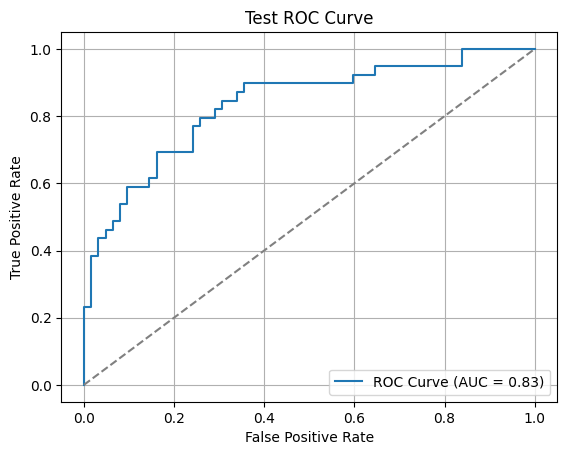

In [14]:
from sklearn.metrics import roc_curve, auc, recall_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = CNNModel().to(device)
best_model.load_state_dict(torch.load("best_model_cnn.pth"))
best_model.eval()
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean.tolist(), std=train_std.tolist())
])

test_dataset = AutismDataset(test_path, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

test_loss = 0.0
correct_test = 0
total_test = 0
test_preds, test_true = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device, dtype=torch.float32).view(-1)
        
        outputs = best_model(inputs).squeeze()
        probs = outputs
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        predicted = (probs > 0.5).float()
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        
        test_preds.extend(probs.cpu().numpy())
        test_true.extend(labels.cpu().numpy())

fpr, tpr, thresholds = roc_curve(test_true, test_preds)
test_auc = auc(fpr, tpr)
test_accuracy = correct_test / total_test
recall = recall_score(test_true, np.array(test_preds) > 0.5)

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [16]:
class AutismDataset1(Dataset):
    def __init__(self, root_dir, type='ind', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.type = type    
        self.data = []
        self.images_all = []
        self.labels_all = []
        self.labels = []
        self.participant_id = []
        for category in os.listdir(root_dir):
            category_dir = os.path.join(root_dir, category)
            if os.path.isdir(category_dir):
                for participant_folder in os.listdir(category_dir):
                    participant_path = os.path.join(category_dir, participant_folder)
                    if os.path.isdir(participant_path):
                        image_paths = []
                        for img_name in os.listdir(participant_path):
                            if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                                img_full_path = os.path.join(participant_path, img_name)
                                if os.path.isfile(img_full_path):
                                    image_paths.append(img_full_path)
                                    self.images_all.append(img_full_path)
                                    self.labels_all.append(0 if category == 'TC' else 1)
                        if image_paths:
                            self.data.append(image_paths)
                            label = 0 if category == 'TC' else 1
                            self.labels.append(label)
                            self.participant_id.append(participant_folder)

    def __len__(self):
        if self.type == 'img':
            return len(self.images_all)
        elif self.type == 'ind':
            return len(self.data)
    
    def __getitem__(self, idx):
        if self.type == 'img':
            image = self.images_all[idx]
            processed_image = self.transform(Image.open(image).convert("RGB"))
            label = self.labels_all[idx]
            return processed_image, label
        elif self.type == 'ind':
            images = self.data[idx]
            label = self.labels[idx]
            processed_images = [self.transform(Image.open(img).convert("RGB")) for img in images]
            return torch.stack(processed_images), label, self.participant_id[idx]
        
        
test_dir = "./Dataset_Split4/Test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean.tolist(), std=train_std.tolist())
])

test_dataset = AutismDataset1(test_dir, type='ind', transform=transform)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

best_model = CNNModel().to(device)
best_model.load_state_dict(torch.load("best_model_cnn.pth"))
best_model.eval()
individual_results = []

with torch.no_grad():
    for images, labels, participant_ids in test_loader:
        labels = labels.to(device)
        for i, participant_images in enumerate(images):
            participant_id = participant_ids[i]
            lbl = labels[i].item()
            preds = []

            for img in participant_images:
                img = img.unsqueeze(0).to(device)
                output = best_model(img)
                pred = (output > 0.5).int().item()
                preds.append(pred)

            positive_preds = sum(preds)
            total_images = len(preds)
            individual_accuracy = positive_preds / total_images
            prediction = 1 if individual_accuracy > 0.5 else 0

            individual_results.append({
                 "Category": "TS" if lbl == 1 else "TC",
                "Participant": participant_id,
                "Prediction": "Autistic" if prediction == 1 else "Not Autistic",
                "Probability": individual_accuracy
            })
    
results_df = pd.DataFrame(individual_results)

print(results_df)

/tmp/ipykernel_708839/551775919.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_model_cnn.pth"))


  Category Participant    Prediction  Probability
0       TC          49  Not Autistic     0.000000
1       TC          31  Not Autistic     0.000000
2       TC          33  Not Autistic     0.052632
3       TC          58  Not Autistic     0.000000
4       TC          48  Not Autistic     0.125000
5       TS           9      Autistic     0.750000
6       TS           4  Not Autistic     0.071429
7       TS          19      Autistic     0.625000
8       TS           8      Autistic     0.600000
